In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import pandas as pd
import numpy as np

In [30]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
try:
    # Attempt to read the file with ISO-8859-1 encoding
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv', encoding='ISO-8859-1')
except UnicodeDecodeError:
    # If the above fails, try another common encoding
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv', encoding='cp1252')
else:
    print("Data loaded successfully.")
df.head()

Data loaded successfully.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Pre-processing -

In [31]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [32]:
df=df.drop(columns=['Description','InvoiceNo'])
df.head(5)

,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,85123A,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,71053,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,84406B,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,84029G,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,84029E,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [33]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [34]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYear'] = df['InvoiceDate'].dt.year

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.drop(columns=['UnitPrice'], inplace=True)
df.head(5)

,StockCode,Quantity,InvoiceDate,CustomerID,Country,InvoiceYear,TotalPrice
0,85123A,6,2010-12-01 08:26:00,17850.0,United Kingdom,2010,15.30
1,71053,6,2010-12-01 08:26:00,17850.0,United Kingdom,2010,20.34
2,84406B,8,2010-12-01 08:26:00,17850.0,United Kingdom,2010,22.00
3,84029G,6,2010-12-01 08:26:00,17850.0,United Kingdom,2010,20.34
4,84029E,6,2010-12-01 08:26:00,17850.0,United Kingdom,2010,20.34


In [35]:
df.drop(columns=['InvoiceDate'], inplace=True)
df['InvoiceYear'].value_counts()

InvoiceYear
2011    499428
2010     42481
Name: count, dtype: int64

In [36]:
# Aggregating data at the customer level
customer_data = df.groupby('CustomerID').agg({
    'InvoiceYear':'count',  # Number of transactions
    'TotalPrice':'sum'  # Total spending
}).reset_index()

# Rename columns for clarity
customer_data.columns = ['CustomerID', 'NumberOfTransactions', 'TotalSpending']

# Display the aggregated data
print(customer_data.head())

   CustomerID  NumberOfTransactions  TotalSpending
0     12346.0                     2           0.00
1     12347.0                   182        4310.00
2     12348.0                    31        1797.24
3     12349.0                    73        1757.55
4     12350.0                    17         334.40


#K-Means Clustering

In [37]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for NumberOfTransactions and TotalSpending
cleaned_data = customer_data.copy()
cleaned_data = remove_outliers_iqr(cleaned_data, 'NumberOfTransactions')
cleaned_data = remove_outliers_iqr(cleaned_data, 'TotalSpending')

# Display the cleaned data
print(cleaned_data.head())

   CustomerID  NumberOfTransactions  TotalSpending
0     12346.0                     2           0.00
2     12348.0                    31        1797.24
3     12349.0                    73        1757.55
4     12350.0                    17         334.40
5     12352.0                    95        1545.41


In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cleaned_data[['NumberOfTransactions', 'TotalSpending']])
scaled_df = pd.DataFrame(scaled_features, columns=['NumberOfTransactions', 'TotalSpending'])

# Assuming 3 clusters is optimal
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y_cleaned = kmeans.fit_predict(scaled_df)

# Add cluster labels to the cleaned DataFrame
cleaned_data['Cluster'] = pred_y_cleaned

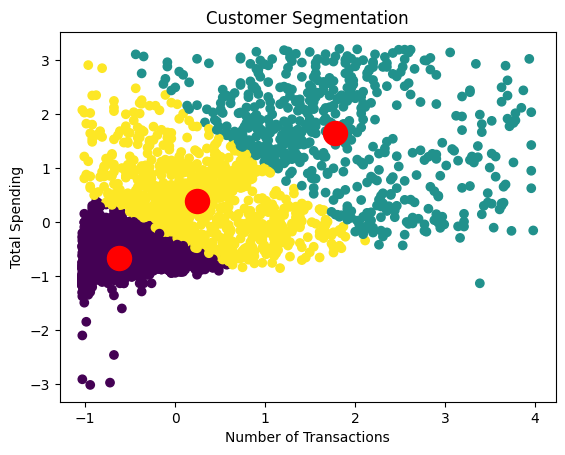

In [39]:
#analysing

plt.scatter(scaled_df['NumberOfTransactions'], scaled_df['TotalSpending'], c=pred_y_cleaned, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.title('Customer Segmentation')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Spending')
plt.show()

#DBSCAN Clustering on Cleaned Data

In [40]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN with chosen parameters
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit and predict clusters on the scaled, cleaned data
clusters = dbscan.fit_predict(scaled_df)

# Assign cluster labels to the DataFrame
cleaned_data['DBSCAN_Cluster'] = clusters

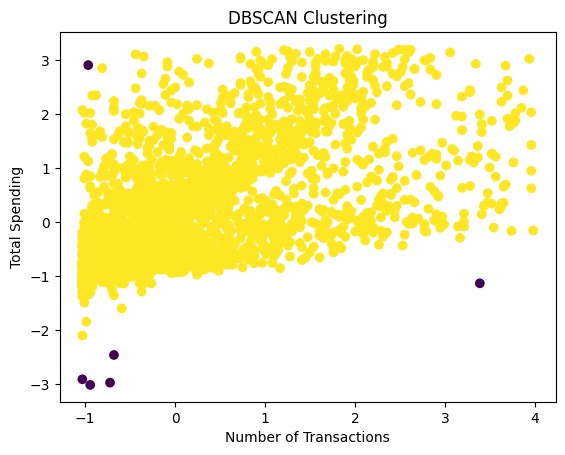

In [41]:
import matplotlib.pyplot as plt

plt.scatter(scaled_df['NumberOfTransactions'], scaled_df['TotalSpending'], c=clusters, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Spending')
plt.show()

DBSCAN automatically labels outliers as -1, providing a straightforward way to identify and exclude noise from the dataset

In [42]:
cluster_counts = pd.Series(clusters).value_counts()
print(cluster_counts)

 0    3661
-1       6
Name: count, dtype: int64


Adjusting eps and min_samples based on initial results and domain knowledge can refine the clustering

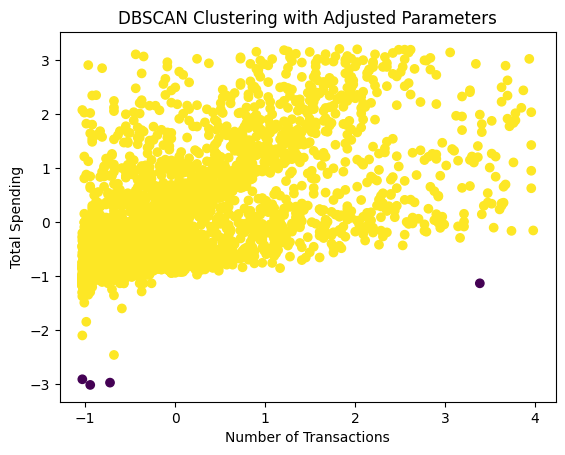

 0    3663
-1       4
Name: count, dtype: int64


In [47]:
# Adjusted parameters based on experimentation
dbscan_adjusted = DBSCAN(eps=0.7, min_samples=20)
clusters_adjusted = dbscan_adjusted.fit_predict(scaled_df)

# Visualization with adjusted parameters
plt.scatter(scaled_df['NumberOfTransactions'], scaled_df['TotalSpending'], c=clusters_adjusted, cmap='viridis')
plt.title('DBSCAN Clustering with Adjusted Parameters')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Spending')
plt.show()

# Analyzing the adjusted clustering
cluster_counts_adjusted = pd.Series(clusters_adjusted).value_counts()
print(cluster_counts_adjusted)

In [48]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Assuming clusters_adjusted are the labels from DBSCAN with adjusted parameters
silhouette_avg = silhouette_score(scaled_df, clusters_adjusted)
calinski_avg = calinski_harabasz_score(scaled_df, clusters_adjusted)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_avg}")

Silhouette Score: 0.5274959933384027
Calinski-Harabasz Index: 12.690336674316878


This process is iterative, requiring analysis of clustering outcomes to refine these parameters. The goal is to find a balance that accurately reflects the underlying data structure, minimizing noise while maintaining distinct clusters